<h1> Loan Prediction </h1>

<h3>Problem Statement</h3>
**About Company**<br/>
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

**Problem**<br/>
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

/home/mayank/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Getting quick data insights

In [3]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [4]:
train.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Getting quick summary for numerical data

In [5]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


We can see that max count is 614. So those who have less than 614 have missing values there

Getting information about non numerical data

In [6]:
train['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

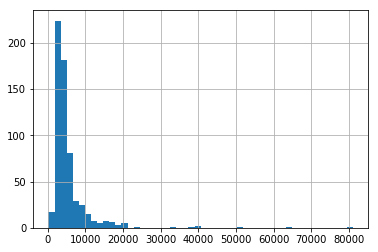

In [7]:
#Lets see the distribution Analysis
train['ApplicantIncome'].hist(bins=50)

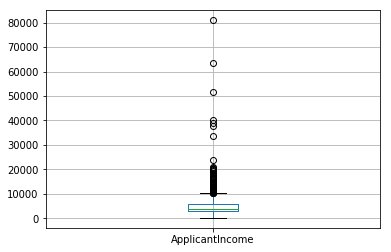

In [8]:
train.boxplot(column='ApplicantIncome')

In [9]:
#check missing values in the dataset
train.apply(lambda x: sum(x.isnull()),axis=0) 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [10]:
values = {
    'Gender' : train.Gender.mode()[0],
    'Married' : train.Married.mode()[0],
    'Dependents' : train.Dependents.mode()[0],
    'Education' : train.Education.mode()[0],
    'Self_Employed' : 'No'
}

train.fillna(value=values, inplace=True)

In [11]:
table = train.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
table

Education,Graduate,Not Graduate
Self_Employed,,
No,130.0,113.0
Yes,157.5,130.0


In [12]:
def fill(x):
 return table.loc[x['Self_Employed'],x['Education']]


# Replace missing values
train['LoanAmount'].fillna(train[train['LoanAmount'].isnull()].apply(fill, axis=1), inplace=True)

In [13]:
def fillCredit(val):
    if val.Loan_Status == 'Y':
        return 1
    else:
        return 0
    

# Replace missing values
train['Credit_History'].fillna(train[train['Credit_History'].isnull()].apply(fillCredit, axis=1), inplace=True)    

In [14]:
def fillTerm(x):
    return train.loc[x['LoanAmount']]['Loan_Amount_Term'].mean()

train['Loan_Amount_Term'].fillna(train[train['Loan_Amount_Term'].isnull()].apply(fillTerm, axis=1), inplace=True)

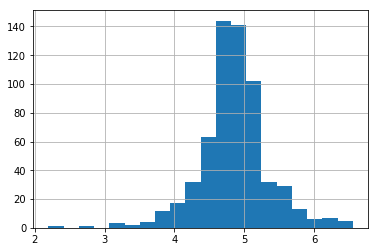

In [15]:
train['LoanAmount_log'] = np.log(train['LoanAmount'])
train['LoanAmount_log'].hist(bins=20)

Now loan Amount distribution look much normal.<br/>
A strong intuition come from that some may have small application income but high support income so better idea is to merge both

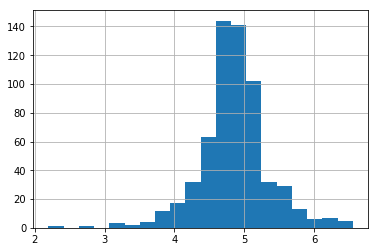

In [16]:
train['TotalIncome'] = train['ApplicantIncome'] + train['CoapplicantIncome']
train['TotalIncome_log'] = np.log(train['TotalIncome'])
train['LoanAmount_log'].hist(bins=20)

**Training Model**

Some model are categorical. Model requires all to be in numeric so it is worth to transform those categorical variable into numerics.

In [17]:
from sklearn.preprocessing import LabelEncoder

var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i])
train.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
LoanAmount_log       float64
TotalIncome          float64
TotalIncome_log      float64
dtype: object

In [18]:
def classification_model(model, data, features, labels):
    
    #Fit the model
    model.fit(data[features], data[labels])
    
    #Make predictions on the training data set
    predictions = model.predict(data[features])
    
    #Print Accuracy
    accuracy =  metrics.accuracy_score(predictions, data[labels])
    print("Accuracy: {0:0.3%}".format(accuracy))
    
    #Perform k cross folds with n=5
    kf = KFold(data.shape[0], n_folds=5)
    error = []
    
    for train, test in kf:
        
        #Filter train data
        train_data_feature = (data[features].iloc[train,:])
    
        #The target variables
        train_data_target = data[labels].iloc[train]
        
        #Training the model using train_feature and train_target
        model.fit(train_data_feature, train_data_target)
        
        #Record error from each cross fold validation term
        error.append(model.score(data[features].iloc[test,:], data[labels].iloc[test]))
        
    
    print("Cross validation score :{0:0.3%}".format(np.mean(error)))
    
    #fit the model again and return
    model.fit(data[features],data[labels])
    
    return model
    

In [19]:
featurevac = ['Gender', 'Married', 'Dependents', 'Education','Self_Employed','LoanAmount',
                 'Loan_Amount_Term', 'Credit_History', 'Property_Area','LoanAmount_log','TotalIncome_log']

label = 'Loan_Status'

In [20]:
#Logistic Regression

model = LogisticRegression()
lrmodel = classification_model(model, train, featurevac, label)

Accuracy: 83.062%
Cross validation score :82.903%


In [21]:
#Random Forest

model = RandomForestClassifier(n_estimators=100)
rfmodel = classification_model(model, train, featurevac, label)

Accuracy: 100.000%
Cross validation score :79.807%


In [22]:
#Decision Tree

model = DecisionTreeClassifier()
dtmodel = classification_model(model, train, featurevac, label)

Accuracy: 100.000%
Cross validation score :73.944%


In [23]:
#Geting feature importance for Random Forest

featimp = pd.Series(rfmodel.feature_importances_, index=featurevac).sort_values(ascending=False)
print(featimp)

Credit_History      0.319698
TotalIncome_log     0.193078
LoanAmount_log      0.140243
LoanAmount          0.137952
Dependents          0.044613
Property_Area       0.043836
Loan_Amount_Term    0.039430
Education           0.023275
Married             0.023230
Gender              0.017871
Self_Employed       0.016771
dtype: float64


In [24]:
#training random forest model again using the stats of feature importance

model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)

featurevar = ['Credit_History','TotalIncome_log','LoanAmount_log','LoanAmount','Property_Area','Dependents']

rfmodel = classification_model(model, train,featurevar,label)

Accuracy: 84.853%
Cross validation score :82.739%


This rf model will now be applied on the test data

**Transforming test data and check that how good our final model predict on that **

In [25]:
test.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [26]:

values1 = {
    'Gender' : test.Gender.mode()[0],
    'Married' : test.Married.mode()[0],
    'Dependents' : test.Dependents.mode()[0],
    'Education' : test.Education.mode()[0],
    'Self_Employed' : 'No',
    'Credit_History' : 0
    }

test.fillna(value=values1, inplace=True)

table = test.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)

test['LoanAmount'].fillna(test[test['LoanAmount'].isnull()].apply(fill, axis=1), inplace=True)
test['Loan_Amount_Term'].fillna(test[test['Loan_Amount_Term'].isnull()].apply(fillTerm, axis=1), inplace=True)

#Adding some more fields that are part of feature colummn
test['LoanAmount_log'] = np.log(test['LoanAmount'])
test['TotalIncome'] = test['ApplicantIncome'] + test['CoapplicantIncome']
test['TotalIncome_log'] = np.log(test['TotalIncome'])
    



In [27]:
var_mod_test = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area']
lt = LabelEncoder()
for i in var_mod_test:
    test[i] = lt.fit_transform(test[i])
test.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
LoanAmount_log       float64
TotalIncome            int64
TotalIncome_log      float64
dtype: object

In [28]:
featurepred = ['Credit_History','TotalIncome_log','LoanAmount_log','LoanAmount','Property_Area','Dependents']

result = rfmodel.predict(test[featurepred])

In [29]:
result = pd.Series(result, name = 'Prediction')
loan_id = test['Loan_ID']

test_result = pd.concat([loan_id, result], axis=1)

Writting the test result into output.csv file with Loan Id and Loan status as 1 and 0

In [30]:
test_result.to_csv('output.csv', sep=',')

**Successfully built and tested **